In [1]:
import psycopg2 as ps
from sshtunnel import SSHTunnelForwarder
import configparser as cp
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


/anaconda3/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Parse configs

In [6]:
userpath = os.path.expanduser("~/")
Config = cp.ConfigParser(interpolation=None)
Config.read("{}{}".format(userpath, ".redshift_creds.ini"))

['/Users/zlee/.redshift_creds.ini']

In [11]:
def ConfigSectionMap(section):
    dict1 = {}
    options = Config.options(section)
    for option in options:
        try:
            dict1[option] = Config.get(section, option)
            if dict1[option] == -1:
                DebugPrint("skip: %s" % option)
        except:
            print("exception on %s!" % option)
            dict1[option] = None
    return dict1

In [12]:
try:
    SSH_USERNAME = ConfigSectionMap("REDSHIFT").get('ssh_username')
    DB_USER = ConfigSectionMap("REDSHIFT").get('db_username')
    DB_PASSWORD = ConfigSectionMap("REDSHIFT").get('db_password')
    DB_PORT = ConfigSectionMap("REDSHIFT").get('db_port')
except Exception as e: 
    print(e)
SSH_PRIVATE_KEY = "~/.ssh/id_rsa"
DB_HOST = '127.0.0.1'


## Open tunnel and connect to db

In [13]:
with SSHTunnelForwarder(
('ec2-107-23-57-72.compute-1.amazonaws.com', 22),
    ssh_username=SSH_USERNAME,
    ssh_private_key=SSH_PRIVATE_KEY,
    remote_bind_address=('localhost', 5439)) as server:

    server.start()
    print("server connected via ssh")
    
    params = {
        'database':'claims',
        'user': DB_USER,
        'password': DB_PASSWORD,
        'host': DB_HOST,
        'port': DB_PORT
    }
    conn = ps.connect(**params)
    curs = conn.cursor()
    print("db connected")


server connected via ssh
db connected


## Get most recent cbrc table name

In [6]:
most_recent_cbrc_table_name_sql = """SELECT tablename
FROM svv_external_tables
WHERE tablename LIKE 'main_raw_cbrc_bronze%'
ORDER BY tablename DESC
LIMIT 1;"""

curs.execute(most_recent_cbrc_table_name_sql)

table_name = curs.fetchall()[0][0]
table_name = "{}{}".format("claims_spectrum.",table_name)

## Count distinct pids

In [7]:
distinct_pids = """select count(distinct gr_pid)
from {};""".format(table_name)
curs.execute(distinct_pids)
distinct_pids_res = pd.DataFrame(curs.fetchall(), columns=['distinct pids'])
distinct_pids_res

,distinct pids
0,1565378


## Average Frequency

In [8]:
average_frequency = """
SELECT AVG(gr_claim_id_count) AS avg_frequency
FROM {}""".format(table_name)
curs.execute(average_frequency)
avg_freq_res = pd.DataFrame(curs.fetchall(), columns=['Average frequency'])
avg_freq_res

,Average frequency
0,2


## Locations per pid frequency distribution

In [9]:
# Note that there is a spike on 20 since we limit the number of visits for a patient to 20 
# in the Topk calculation in bronze
locations_per_pid_freq_dist = """
SELECT number_of_visits,
       COUNT(number_of_visits) num_of_visits_count_freq
FROM (
       SELECT gr_pid,
              COUNT(normalized_npi) number_of_visits
       FROM {}
       GROUP BY gr_pid
     ) AS base
GROUP BY number_of_visits
ORDER BY number_of_visits DESC;
""".format(table_name)

curs.execute(locations_per_pid_freq_dist)
loc_per_pid_res = pd.DataFrame(curs.fetchall(), columns=['A. Number of NPI visited', 'Count of pids with A'])
loc_per_pid_res

,A. Number of NPI visited,Count of pids with A
0,20,38700
1,19,6102
2,18,7179
3,17,8869
4,16,10471
5,15,12878
6,14,15668
7,13,19061
8,12,23050
9,11,29146


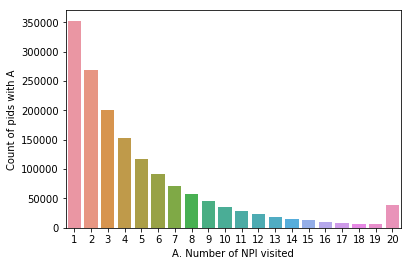

In [10]:
sns.barplot(x='A. Number of NPI visited', y='Count of pids with A', data=loc_per_pid_res)

## Records per month

In [11]:
records_per_month = """
SELECT COUNT(*), date_trunc('mon', visit_end_date) as month
FROM {}
GROUP BY date_trunc('mon', visit_end_date)
ORDER BY month ASC""".format(table_name)

curs.execute(records_per_month)
rec_per_month_res = pd.DataFrame(curs.fetchall(), columns=['Count of visits', 'date'])
rec_per_month_res

,Count of visits,date
0,270006,2018-03-01
1,568817,2018-04-01
2,609884,2018-05-01
3,589649,2018-06-01
4,601123,2018-07-01
5,693933,2018-08-01
6,645457,2018-09-01
7,818307,2018-10-01
8,791992,2018-11-01
9,841775,2018-12-01


## Log Based Histogram to track number of pids per location

In [12]:
# log based
visits_per_location_hist = """
SELECT Count(b.count_of_count_per_npi) as cc,
       count_of_count_per_npi
FROM
(
  SELECT cast(log(number_of_visits) AS int) count_of_count_per_npi

  FROM (
         SELECT normalized_npi,
                COUNT(gr_pid) number_of_visits
         FROM {}
         GROUP BY normalized_npi
       ) AS base
) as b
GROUP BY count_of_count_per_npi
ORDER BY count_of_count_per_npi;""".format(table_name)

curs.execute(visits_per_location_hist)
visits_per_loc_hist_res = pd.DataFrame(curs.fetchall(), columns=['count', 'log based'])
visits_per_loc_hist_res

,count,log based
0,864176,0
1,157696,1
2,4678,2
3,193,3
4,14,4


In [14]:
conn.close()